In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import os
import time
from gprofiler import GProfiler
import gzip

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# # Raw data 
# # For genes, norm data = raw data + 10k size-factor + log1p transform
# # For proteins, norm data = raw data + gmean(data+1) size-factor +log1p transform
# DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/nathan_ni_2021'
# df_data_meta = pd.read_csv(DATA_PATH+'/raw_data/GSE158769_meta_data.txt.gz', 
#                            sep='\t', index_col=0)

In [21]:
# # Read and save count data 
# sp_data = []
# gene_list = []
# cell_list = []
# with gzip.open(DATA_PATH+'/raw_data/GSE158769_exprs_raw.tsv.gz','r') as f:
#     for i_line,line in enumerate(f):
#         line = line.decode().strip().split('\t')
#         if i_line==0:
#             cell_list = line[1:]
#         else:
#             gene_list.append(line[0])
#             data = np.array(line[1:], dtype=int)
#             data = sp.sparse.coo_matrix(data)
#             sp_data.append(data)    
# #         if i_line>3:
# #             break
# sp_data = sp.sparse.vstack(sp_data)
# sp_data = sp.sparse.csr_matrix(sp_data)
# df_obs = pd.DataFrame(index=cell_list)
# df_var = pd.DataFrame(index=gene_list)
# adata_raw = AnnData(sp_data.T, obs=df_obs, var=df_var)
# adata_raw.obs = adata_raw.obs.join(df_data_meta)

# # Put protein measurements in .obs
# protein_list = [x for x in adata_raw.var_names if '_protein' in x]
# temp_df = pd.DataFrame(columns=adata_raw.obs_names, index=protein_list, 
#                        data=adata_raw[:,protein_list].X.toarray().T, dtype=float)
# g_mean = sp.stats.mstats.gmean(temp_df+1, axis=0)
# temp_df = np.log(temp_df/g_mean+1).T
# adata_raw.obs = adata_raw.obs.join(temp_df)
# adata_raw = adata_raw[:,~adata_raw.var_names.isin(protein_list)]

# # Filter genes 
# print('# Before filtering', adata_raw.shape)
# sc.pp.filter_genes(adata_raw, min_cells=100)
# print('# After filtering', adata_raw.shape)
# adata_raw.write(DATA_PATH+'/obj_raw.h5ad')

# Before filtering (500089, 33538)


Trying to set attribute `.var` of view, copying.


# After filtering (500089, 17256)


... storing 'TB_status' as categorical
... storing 'cluster_name' as categorical
... storing 'cluster_ids' as categorical


In [4]:
# Compare with norm data 

In [64]:
# # Check transformation 
# df_data_raw = pd.read_csv(DATA_PATH+'/raw_data/GSE158769_exprs_raw.tsv.gz',
#                           sep='\t', index_col=0, usecols=[0,1,2,3])
# df_data_norm = pd.read_csv(DATA_PATH+'/raw_data/GSE158769_exprs_norm.tsv.gz',
#                            sep='\t', index_col=0, usecols=[0,1,2,3])

# protein_list = [x for x in df_data_raw.index if '_protein' in x]
# gene_list = [x for x in df_data_raw.index if '_protein' not in x]

# # Protein transformation
# temp_df = df_data_raw.loc[protein_list].copy()
# g_mean = sp.stats.mstats.gmean(temp_df+1, axis=0)
# temp_df = np.log(temp_df/g_mean+1)
# display(temp_df.loc[protein_list[:3]])
# display(df_data_norm.loc[protein_list[:3]])

# # Gene transformation
# temp_df = df_data_raw.loc[gene_list].copy()
# temp_df = temp_df / temp_df.sum(axis=0)*10000
# temp_df = np.log(temp_df+1)
# display(temp_df.loc[temp_df.sum(axis=1)>2].iloc[:3])
# display(df_data_norm.loc[df_data_norm.sum(axis=1)>2].iloc[:3])

,AAACCCAAGGCCTAAG-1,AAACCCAAGGTTCTTG-1,AAACCCAAGTGCAGGT-1
gene,,,
CD4_protein,3.336425,3.342440,2.923754
CD25_protein,0.111918,0.000000,1.008964
CD26_protein,1.434458,0.279853,1.297463


,AAACCCAAGGCCTAAG-1,AAACCCAAGGTTCTTG-1,AAACCCAAGTGCAGGT-1
gene,,,
CD4_protein,3.336430,3.342440,2.92375
CD25_protein,0.111918,0.000000,1.00896
CD26_protein,1.434460,0.279853,1.29746


### Processed data

In [2]:
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/nathan_ni_2021'
adata_raw = sc.read_h5ad(DATA_PATH+'/obj_raw.h5ad')

In [13]:
# df_data_norm = pd.read_csv(DATA_PATH+'/raw_data/GSE158769_exprs_norm.tsv.gz',
#                            sep='\t', index_col=0, usecols=[0,1,2])

# # Check protein list
# protein_list = [x for x in adata_raw.obs.columns if '_protein' in x]
# display(df_data_norm.loc[protein_list[:3]])
# display(adata_raw.obs.loc[df_data_norm.columns, protein_list[:3]])

# # Check norm_gene 
# temp_data = adata_raw[df_data_norm.columns,:].copy()
# sc.pp.normalize_per_cell(temp_data, counts_per_cell_after=1e4)
# sc.pp.log1p(temp_data)
# gene_list = df_data_norm.index[df_data_norm.sum(axis=1)>1]
# display(df_data_norm.loc[gene_list[:3]])
# display(temp_data[:,gene_list[:3]].X.toarray())

,AAACCCAAGGCCTAAG-1,AAACCCAAGGTTCTTG-1
gene,,
CD4_protein,3.336430,3.342440
CD25_protein,0.111918,0.000000
CD26_protein,1.434460,0.279853


,CD4_protein,CD25_protein,CD26_protein
AAACCCAAGGCCTAAG-1,3.336425,0.111918,1.434458
AAACCCAAGGTTCTTG-1,3.342440,0.000000,0.279853


,AAACCCAAGGCCTAAG-1,AAACCCAAGGTTCTTG-1
gene,,
NOC2L,0.969717,1.26158
MRPL20,0.000000,1.26158
SSU72,1.452640,0.00000


array([[0.9697166, 0.       , 1.4526423],
       [1.2617639, 1.2617639, 0.       ]], dtype=float32)

In [3]:
# Make .cov file 
df_cov = pd.DataFrame(index=adata_raw.obs.index)
df_cov['n_genes'] = adata_raw.obs['nGene']
for batch in set(adata_raw.obs['batch']):
    df_cov['batch%d'%batch] = (adata_raw.obs['batch']==batch)*1
df_cov.to_csv(DATA_PATH+'/nathan_ni_2021.cov', sep='\t')

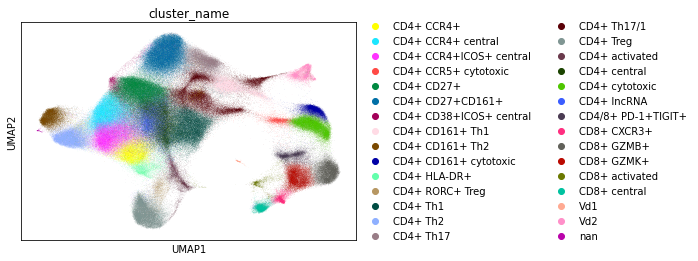

In [21]:
adata = adata_raw.copy()
adata.obsm['X_umap'] = adata.obs[['UMAP_1', 'UMAP_2']]
sc.pl.umap(adata, color=['cluster_name'])

### Subsample data 

In [15]:
n_batch = 4
batch_size = np.ceil(adata_raw.shape[0]/n_batch).astype(int)
np.random.seed(0)
cell_list = np.random.permutation(adata_raw.obs_names)
for i in range(n_batch):
    cell_list_sub = cell_list[i*batch_size:(i+1)*batch_size]
    print(len(cell_list_sub))
    adata_raw[cell_list_sub,:].write(DATA_PATH+'/obj_raw.b%d.h5ad'%i)
    df_cov.loc[cell_list_sub].to_csv(DATA_PATH+'/nathan_ni_2021.b%d.cov'%i, sep='\t')

125023
125023
125023
125020
